In [1]:
# general python modules
import sys, os, pprint, pandas
import numpy as np
import matplotlib.pylab as plt
from scipy import stats

#sys.path.append('./')
from analysis import compute_tuning_response_per_cells, shift_orientation_according_to_pref
sys.path.append('../physion/src')
from physion.analysis.read_NWB import Data, scan_folder_for_NWBfiles
from physion.analysis.process_NWB import EpisodeData
sys.path.append('../')
import plot_tools as pt

root_folder = os.path.join(os.path.expanduser('~'), 'CURATED', 'SST-FF-Gratings-Stim')

import warnings
warnings.filterwarnings("ignore") # disable the UserWarning from pynwb (arrays are not well oriented)

 /!\  "svgutils" not installed ! get it with: "pip install svgutils" 


## Build the dataset from the NWB files

In [2]:
DATASET = {\
    'WT':scan_folder_for_NWBfiles(os.path.join(root_folder, 'Wild-Type'), verbose=False),
    'KO':scan_folder_for_NWBfiles(os.path.join(root_folder, 'GluN1-KO'), verbose=False),
}

In [3]:
# -------------------------------------------------- #
# ----   Loop over datafiles               --------- #
# -------------------------------------------------- #

def orientation_selectivity_index(resp_pref, resp_90):
    """                                                                         
     computes the selectivity index: (Pref-Orth)/Pref
     clipped in [0,1] --> because resp_90 can be negative    
    """
    return (resp_pref-np.clip(resp_90, 0, np.inf))/resp_pref

stat_test_props = dict(interval_pre=[-1.5,0],
                       interval_post=[1,2.5],
                       test='ttest',
                       positive=True)


#contrast = build_contrast_trace(data)
    

TAU_DECONVOLUTION = 1.3

dFoF_parameters = dict(\
        roi_to_neuropil_fluo_inclusion_factor=1.15,
        neuropil_correction_factor = 0.7,
        method_for_F0 = 'sliding_percentile',
        percentile=5., # percent
        sliding_window = 5*60, # seconds
)

def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = {}
    
    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key] = {'subjects':[], 'tstart':[], 'tstop':[]}
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['RESPONSES_c=%.1f' % contrast], SUMMARY[key]['OSI_c=%.1f' % contrast] = [], []
            SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast], SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast] = [], []
            
        for f, s in zip(DATASET[key]['files'][:Nmax], DATASET[key]['subjects'][:Nmax]):
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.init_visual_stim()
            #Dcnv = oasis(data.dFoF, data.dFoF.shape[0], TAU_DECONVOLUTION, 1./data.CaImaging_dt)

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            pCond = data.get_protocol_cond(protocol_id=data.get_protocol_id(protocol_name=protocol))
            # start and stop of the grating protocol (in case of rec. with other protocols)
            SUMMARY[key]['tstart'].append(np.min(data.visual_stim.experiment['time_start'][pCond]))
            SUMMARY[key]['tstop'].append(np.max(data.visual_stim.experiment['time_stop'][pCond]))
            
            for contrast in [0.5, 1]:
                
                responses, significant, shifted_angle = compute_tuning_response_per_cells(data,
                                                                                          imaging_quantity='dFoF',
                                                                                          contrast=contrast,
                                                                                          protocol_name=protocol,
                                                                                          stat_test_props=stat_test_props,
                                                                                          response_significance_threshold=\
                                                                                                      response_significance_threshold,
                                                                                          verbose=False)
                
                SUMMARY[key]['RESPONSES_c=%.1f' % contrast].append(responses)
                SUMMARY[key]['OSI_c=%.1f' % contrast].append([orientation_selectivity_index(r[1], r[5]) for r in responses])
                SUMMARY[key]['FRAC_RESP_c=%.1f' % contrast].append(np.sum(significant)/len(significant))
                SUMMARY[key]['SIGNIFICANT_c=%.1f' % contrast].append(significant)
                
    SUMMARY['shifted_angle'] = shifted_angle
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-episodes.npy', SUMMARY)

analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-13-30-47.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-14-05-01.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-15-10-04.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-15-48-06.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-15-30-46.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-16-15-09.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-17-02-46.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-17-39-12.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_03_28-12-31-50.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_03_31-12-55-47.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Typ

# Responsiveness to visual stimulation

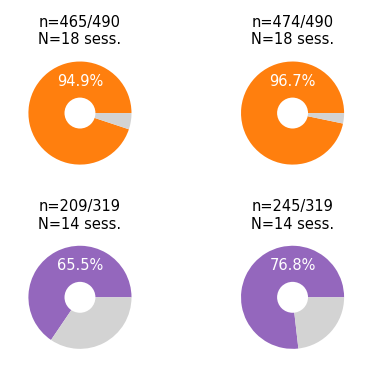

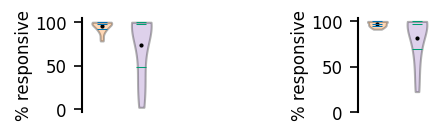

In [4]:
from scipy import stats

SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

fig1, AX1 = pt.figure(axes=(2,2),figsize=(1.,1.2))

cases, colors = ['WT', 'KO'], ['tab:orange', 'tab:purple']

for i, case in enumerate(cases):
    for c, contrast in enumerate([0.5, 1.0]):
        resp = np.sum([np.sum(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        tot = np.sum([len(r) for r in SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast]])
        pt.pie([100*resp/tot, 100*(1-resp/tot)], ax=AX1[i][c], COLORS=[colors[i], 'lightgrey'])
        pt.annotate(AX1[i][c], '%.1f%%' % (100*resp/tot), (.5,.85), va='top', ha='center',color='w', fontsize=7)
        AX1[i][c].set_title('n=%i/%i\nN=%i sess.' % (resp,tot,len(SUMMARY[case]['SIGNIFICANT_c=%.1f' % contrast])), fontsize=7)

fig2, AX2 = pt.figure(axes=(2,1), figsize=(.6,1.), wspace=5.)
for c, contrast in enumerate([0.5, 1.0]):
    for i, case in enumerate(cases):
        frac = 100*np.mean([r for r in SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]])
        pt.violin(100*np.array(SUMMARY[case]['FRAC_RESP_c=%.1f' % contrast]),
                  X=[i], COLORS=[colors[i]], ax=AX2[c])
    pt.set_plot(AX2[c], ['left'], ylabel='% responsive', yticks=[0,50,100])
stats.mannwhitneyu(SUMMARY['WT']['FRAC_RESP_c=1.0'], SUMMARY['KO']['FRAC_RESP_c=1.0'])

fig1.savefig('../figures/in-vivo/summary-responsiveness.svg')

# Orientation tuning

In [6]:
def build_resp(SUMMARY, key, contrast, average_by='sessions'):
    
    if average_by=='sessions':
        resp = np.array([np.mean(r, axis=0) for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
    else:
        resp = np.concatenate([r for r in SUMMARY[key]['RESPONSES_c=%.1f' % contrast]])
        
    resp = np.clip(resp, 0, np.inf) # CLIP RESPONSIVE TO POSITIVE VALUES

    return resp

## Analysis per session

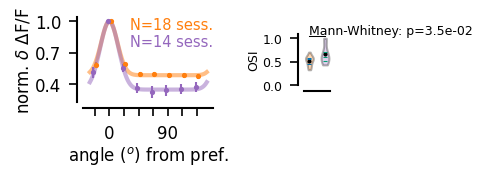

In [17]:
from scipy.optimize import minimize

def func(S, X):
    """ fitting function """
    nS = (S+90)%180-90
    return X[0]*np.exp(-(nS**2/2./X[1]**2))+X[2]

def selectivity_index(resp1, resp2):
    return (resp1-np.clip(resp2, 0, np.inf))/resp1


#fig, ax = plt.subplots(1, figsize=(2, 1))
fig, ax = pt.figure(figsize=(1,0.9), right=10.)
#plt.subplots_adjust(top=0.9, bottom=0.2, right=0.6)
inset = pt.inset(ax, (1.7, 0.2, 0.2, 0.6))

colors = ['tab:orange', 'tab:purple']
norm='norm .'
ms=1.5
contrast = 1. # at full contrast
SIs = []

for i, key in enumerate(cases):

    resp = build_resp(SUMMARY, key, contrast, average_by='sessions')
    pt.annotate(ax, i*'\n'+'N=%i sess.'%len(resp), (1,1), ha='right', va='top', 
                color=colors[i], fontsize=7)
    # norm. to max
    resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
        
    SIs.append([selectivity_index(r[1], r[5]) for r in resp])

    # data
    pt.scatter(SUMMARY['shifted_angle']+(1-2*i)*2, np.mean(resp, axis=0),
               sy=stats.sem(resp, axis=0), ax=ax, color=colors[i], ms=ms)
    
    # fit
    def to_minimize(x0):
        return np.sum((resp.mean(axis=0)-\
                       func(SUMMARY['shifted_angle'], x0))**2)
    
    res = minimize(to_minimize,
                   [0.8, 10, 0.2])
    x = np.linspace(-30, 180-30, 100)
    ax.plot(x, func(x, res.x), lw=2, alpha=.5, color=colors[i])

# selectivity index
for i, key in enumerate(cases):
    pt.violin(SIs[i], X=[i], ax=inset, COLORS=[colors[i]])
if len(cases)==2:
    inset.plot([0,1], 1.05*np.ones(2), 'k-', lw=0.5)
    inset.annotate('Mann-Whitney: p=%.1e' % stats.mannwhitneyu(SIs[0], SIs[1]).pvalue,
                   (0, 1.09), fontsize=6)
pt.set_plot(inset, xticks=[], ylabel='OSI',
            yticks=[0, 0.5, 1], ylim=[0, 1.09],
            fontsize=6)

ylabel='norm. $\delta$ $\Delta$F/F'
pt.set_plot(ax, xlabel='angle ($^o$) from pref.',
            ylabel=ylabel,
            yticks=[0.4,0.7,1],
            xticks=SUMMARY['shifted_angle'],
            xticks_labels=['%.0f'%s if (i%4==1) else '' for i,s in enumerate(SUMMARY['shifted_angle'])])
fig.savefig('../figures/in-vivo/summary-tuning-per-session.svg')

## Analysis per ROIs

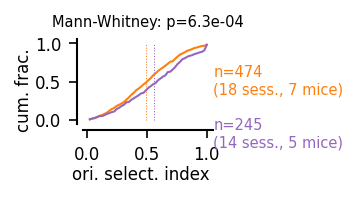

In [16]:

fig, ax = pt.figure(figsize=(1,0.9))

colors = ['tab:orange', 'tab:purple']
contrast = 1.0
SIs = []

bins = np.linspace(0, 1, 50)

for i, key in enumerate(cases):

    resp = build_resp(SUMMARY, key, contrast, average_by='cells')
    # norm. to max
    resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))

    SIs.append([selectivity_index(r[1], r[5]) for r in resp])
    
    hist, be = np.histogram(SIs[-1], bins=bins, density=True)
    
    ax.plot(be[1:], np.cumsum(hist)/len(bins), color=colors[i])
    ax.plot(np.mean(SIs[-1])*np.ones(2), [0,1], ':', color=colors[i], lw=0.5)
    
    pt.annotate(ax, 3*i*'\n'+'\nn=%i\n(%i sess., %i mice)' % (len(resp),
                                                    len(SUMMARY[key]['RESPONSES_c=%.1f' % contrast]),
                                                        len(np.unique(SUMMARY[key]['subjects']))),
                   (1,0.9), fontsize=7,
                   va='top',color=colors[i])
        
    
if len(cases)==2:
    ax.set_title('Mann-Whitney: p=%.1e' % stats.mannwhitneyu(SIs[0], SIs[1]).pvalue, fontsize=7)

pt.set_plot(ax, xlabel='ori. select. index   ',
            yticks=[0,0.5,1],
            xticks=[0,0.5,1],
            ylabel='cum. frac.   ')
fig.savefig('../figures/in-vivo/summary-tuning-per-cell.svg')

# Temporal dynamics

In [ ]:
import sys
sys.path.append('..')
from visual_coding.analysis import crosscorrel # plot_tools and CC-function
from physion.imaging.dcnv import oasis
#############################
#####   contrast curve  #####
#############################

def build_contrast_trace(data):
    contrast = 0*data.t_dFoF
    for tstart, tstop, c in zip(data.visual_stim.experiment['time_start'],
                                data.visual_stim.experiment['time_stop'],
                                data.visual_stim.experiment['contrast']):
        cond = (data.t_dFoF>tstart) & (data.t_dFoF<tstop)
        contrast[cond] = c
    return contrast


############################
#####   deconvolution  #####
############################

TAU_DECONVOLUTION = 1.5

CC_window = 8.

for key in ['WT', 'KO']:
    
    SUMMARY[key]['responsive_Deconvolved'] = []
    SUMMARY[key]['responsive_CCs'] = []
    SUMMARY[key]['contrast_CCs'] = []
    SUMMARY[key]['contrast'] = []

    for i in range(len(DATASET[key]['files'])):
        
        responsive = np.array(SUMMARY[key]['SIGNIFICANT_c=1.0'][i], dtype=bool) # at full contrast
        
        data = Data(DATASET[key]['files'][i], verbose=False)
        
        data.build_dFoF(**dFoF_parameters, verbose=False)

        # now focus on 
        tCond = (data.t_dFoF>SUMMARY[key]['tstart'][i]) & (data.t_dFoF<SUMMARY[key]['tstop'][i])
        SUMMARY[key]['responsive_Deconvolved'].append(\
            oasis(data.dFoF[responsive,:][:,tCond],
                     len(data.t_dFoF[tCond]), TAU_DECONVOLUTION, 1./data.CaImaging_dt))
        
        data.init_visual_stim()
        SUMMARY[key]['contrast'].append(build_contrast_trace(data)[tCond])

        SUMMARY[key]['responsive_CCs'].append([])
        for c in range(SUMMARY[key]['responsive_Deconvolved'][-1].shape[0]):
            CCF, time_shift = crosscorrel(SUMMARY[key]['contrast'][-1], SUMMARY[key]['responsive_Deconvolved'][-1][c,:],
                                          CC_window, 1e-3/data.CaImaging_dt)
            SUMMARY[key]['responsive_CCs'][-1].append(CCF)
        SUMMARY[key]['contrast_CCs'].append(crosscorrel(SUMMARY[key]['contrast'][-1], SUMMARY[key]['contrast'][-1],
                                            CC_window, 1e-3/data.CaImaging_dt))

SUMMARY['time_shift'] = time_shift

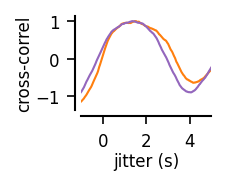

In [52]:
fig, ax = pt.figure()

SUMMARY['time_shift'] = time_shift
for key, c in zip(['WT', 'KO'], ['tab:orange', 'tab:purple']):

    responsive_CCs = np.concatenate(SUMMARY[key]['responsive_CCs'])
    responsive_CCs = np.mean(SUMMARY[key]['responsive_CCs'], axis=0)
    responsive_CCs = np.divide(responsive_CCs, np.max(responsive_CCs, axis=1, keepdims=True))
    #print(responsive_CCs)
    pt.plot(SUMMARY['time_shift'], np.mean(responsive_CCs, axis=0)/np.mean(responsive_CCs, axis=0).max(),
            sy=stats.sem(responsive_CCs, axis=0),
            color=c, ax=ax)

pt.set_plot(ax, xlim=[-1,5], xlabel='jitter (s)', ylabel='cross-correl')

In [19]:
# -------------------------------------------------- #
# ----   Loop over datafiles               --------- #
# -------------------------------------------------- #

def orientation_selectivity_index(resp_pref, resp_90):
    """                                                                         
     computes the selectivity index: (Pref-Orth)/Pref
     clipped in [0,1] --> because resp_90 can be negative    
    """
    return (resp_pref-np.clip(resp_90, 0, np.inf))/resp_pref

stat_test_props = dict(interval_pre=[-1.5,0],
                       interval_post=[1,2.5],
                       test='ttest',
                       positive=True)


TAU_DECONVOLUTION = 1.5

dFoF_parameters = dict(\
        roi_to_neuropil_fluo_inclusion_factor=1.15,
        neuropil_correction_factor = 0.7,
        method_for_F0 = 'sliding_percentile',
        percentile=5., # percent
        sliding_window = 5*60, # seconds
        smoothing=1.5,
)


def compute_summary_responses(DATASET,
                              Nmax=999, # max datafiles (for debugging)
                              stat_test_props=dict(interval_pre=[-1.,0],                                   
                                                   interval_post=[1.,2.],                                   
                                                   test='anova',                                            
                                                   positive=True),
                              response_significance_threshold=5e-2,
                              verbose=True):
    
    SUMMARY = np.load('../data/in-vivo/summary-episodes.npy', allow_pickle=True).item()

    SUMMARY['dFoF_args'] = dFoF_parameters
    
    for key in ['WT', 'KO']:
        SUMMARY[key] = {'subjects':[], 'tstart':[], 'tstop':[]}
        
        for contrast in [0.5, 1]:
            SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast] = []
            
        for f, s, significant in zip(DATASET[key]['files'][:Nmax],
                                     DATASET[key]['subjects'],
                                     SUMMARY[key]['SIGNFICANT_c=1.0']):
            
            SUMMARY[key]['subjects'].append(s)
            print('analyzing "%s" [...] ' % f)
            data = Data(f, verbose=False)
            
            data.build_dFoF(**dFoF_parameters, verbose=False)
            data.build_Deconvolved(Tau=TAU_DECONVOLUTION)
            data.init_visual_stim()

            protocol = 'ff-gratings-8orientation-2contrasts-15repeats' if\
                        ('ff-gratings-8orientation-2contrasts-15repeats' in data.protocols) else\
                        'ff-gratings-8orientation-2contrasts-10repeats'

            for contrast in [0.5, 1]:
                
                t, significant_waveforms = compute_tuning_response_per_cells(data,
                                                                             prestim_duration=2.5,
                                                                             imaging_quantity='Deconvolved',
                                                                             contrast=contrast,
                                                                             protocol_name=protocol,
                                                                             stat_test_props=stat_test_props,
                                                                             response_significance_threshold=\
                                                                                          response_significance_threshold,
                                                                             verbose=False,
                                                                             return_significant_waveforms=True)
                
                SUMMARY[key]['WAVEFORMS_c=%.1f' % contrast].append(significant_waveforms)
                
    SUMMARY['t'] = t
    print('done ! ')
    
    return SUMMARY

SUMMARY = compute_summary_responses(DATASET,
                                    verbose=False)
np.save('../data/in-vivo/summary-deconvolved.npy', SUMMARY)

analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-13-30-47.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-14-05-01.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-15-10-04.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_15-15-48-06.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-15-30-46.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-16-15-09.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-17-02-46.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_02_17-17-39-12.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_03_28-12-31-50.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Type/2023_03_31-12-55-47.nwb" [...] 
analyzing "/Users/yann/CURATED/SST-FF-Gratings-Stim/Wild-Typ

In [67]:
def gaussian(t, X):
    return (1-X[1])*np.exp(-t**2/2/X[0]**2)+X[1]
                 
def fit_gaussian_width(shift, array,
                       min_time=0.2,
                       max_time=2.5):
    def func(X):
        return np.sum(np.abs(gaussian(shift, X)-array))
    res = minimize(func, [3*min_time,0,1],
                   bounds=[[min_time, max_time],
                           [-max_time, max_time],
                           [0,1]], method='L-BFGS-B')
    return res.x

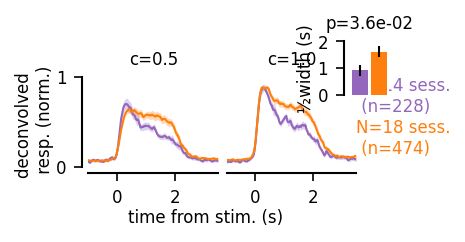

In [68]:
SUMMARY = np.load('../data/in-vivo/summary-deconvolved.npy', allow_pickle=True).item()

fig, AX = pt.figure(axes=(2,1),figsize=(1.,0.95),wspace=0.1)

cases, colors = ['KO', 'WT'], ['tab:purple', 'tab:orange']

inset = pt.inset(AX[1], [0.95,0.8,0.3,0.6])

fitInterval = [0.5, 2.5]
Widths = {}
for i, case in enumerate(cases):
    Widths[case] = []
    c1 = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=1.0']]
    for c, contrast in enumerate([0.5, 1.0]):

        resp = [np.mean(r, axis=0) for r in SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]]
        #resp = np.divide(resp, np.max(resp, axis=1, keepdims=True))
        resp = np.divide(resp, np.max(c1, axis=1, keepdims=True))
        
        pt.plot(SUMMARY['t'], np.mean(resp, axis=0),#/np.mean(responsive_CCs, axis=0).max(),
                sy=stats.sem(resp, axis=0),
                #sy=np.std(resp, axis=0),
                color=colors[i], ax=AX[c])
        if c:
            pt.annotate(AX[c],2*i*'\n'+'N=%i sess.\n (n=%i)' % (\
                            len(SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]),
                            np.sum([len(r) for r in SUMMARY[case]['WAVEFORMS_c=%.1f' % contrast]])),
                        (1,1), va='top', color=colors[i])
    # fit here, i.e. at full contrast
    cond = (SUMMARY['t']>fitInterval[0]) & (SUMMARY['t']<fitInterval[1]) 
    for iSession in range(len(resp)):
        Widths[case].append(fit_gaussian_width(SUMMARY['t'][cond]-fitInterval[0],
                            resp[iSession][cond]/np.max(resp[iSession][cond]))[0])
    inset.bar([i], [np.mean(Widths[case])], yerr=[stats.sem(Widths[case])], color=colors[i])
    
pt.set_plot(inset, ['left'], 
            title='p=%.1e' % stats.mannwhitneyu(Widths['WT'], Widths['KO']).pvalue,
            ylabel=u'\u00bd' + 'width (s)', yticks=[0,1,2])

for c, contrast in enumerate([0.5, 1.0]):
    pt.set_plot(AX[c], ['left','bottom'] if c==0 else ['bottom'],
                xlim=[-1,3.5], yticks=[0,1], xticks=[0,2],
                yticks_labels=['0','1'] if c==0 else [],
                ylim=[0,1], 
                ylabel='deconvolved \n resp. (norm.)' if c==0 else '',
                title='c=%.1f' % contrast,
                xlabel=20*' '+'time from stim. (s)' if c==0 else '')
fig.savefig('../figures/in-vivo/summary-evoked-resp.svg')